# Malware Classification:Logistic Regression

## this supervised machine learning model takes a csv consisting of 100,000 rows of data with 35 feature columns describing various apects of computer files that are labeled as either malware or benign and uses it to differentiate between safe computer files and dangerous computer files.



In [30]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
import itertools
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
import timeit
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [31]:
def PreProcessing(data):

    data1 = data.dropna(how="any", axis=0)
    data1["classification"].value_counts()
    data1['classification'] = data1.classification.map({'benign': 0, 'malware': 1})
    return data1


In [32]:
def Visualize(data):
    sns.countplot(data["classification"])
    plt.show()

    data["classification"].value_counts().plot(kind="pie", autopct="%1.1f%%")
    plt.axis("equal")
    plt.show()



In [33]:

def construct_quality_report(abt):

    excluded_columns = ['classification', 'hash', ]

    summary_feature_names = ['Feature Name', 'Cardinality', 'Non-null Count', 'Null Count', 'Min', '25th', 'Mean',
                             '50th', '75th', 'Max', 'Std. Dev', 'Outlier Count Low', 'Outlier Count High']
    QRDF = pd.DataFrame(columns=summary_feature_names)
    NewData = dict.fromkeys(summary_feature_names)

    for x in abt.columns:

        if x in excluded_columns:
            continue
        NewData['Feature Name'] = x
        NewData['Cardinality'] = abt[x].nunique()
        NewData['Non-null Count'] = abt[x].count()
        NewData['Null Count'] = abt[x].isna().sum()
        NewData['Min'] = abt[x].to_numpy().min()
        NewData['25th'] = np.percentile(abt[x].to_numpy(), 25)
        NewData['Mean'] = np.mean(abt[x].to_numpy())
        NewData['50th'] = np.percentile(abt[x].to_numpy(), 50)
        NewData['75th'] = np.percentile(abt[x].to_numpy(), 75)
        NewData['Max'] = abt[x].to_numpy().max()
        NewData['Std. Dev'] = np.std(abt[x].to_numpy())
        q1 = abt[x].quantile(0.25)
        q3 = abt[x].quantile(0.75)
        iqr = q3 - q1
        NewData['Outlier Count Low'] = abt[x].lt(q1 - (1.5 * iqr)).sum()
        NewData['Outlier Count High'] = abt[x].gt(q3 + (1.5 * iqr)).sum()
        values = NewData.values()
        QRDF.loc[len(QRDF)] = list(values)


    return QRDF

    pass



In [34]:

def drop_low_card_data(summary_table,abt) :

    Name = summary_table['Feature Name']
    Cardin = summary_table['Cardinality']


    count = 0

    for x, y in zip(Name, Cardin):

        if y < 3:
            # print(y)
            abt.drop(x, axis=1, inplace=True)
            continue
        count = count + 1

    summary_table.drop(summary_table[summary_table['Cardinality'] < 3].index, inplace=True)
    return summary_table, abt



    pass



In [35]:

def LogisticRegressionModel(data):
    benign1 = data.loc[data['classification'] == 'benign']
    benign1["classification"].head()
    malware1 = data.loc[data['classification'] == 'malware']
    malware1["classification"].head()
    corr = data.corr()
    corr.nlargest(35, 'classification')["classification"]
    x = data.drop(["hash", "classification"],axis=1)
    y = data["classification"]

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.7, random_state=1)









    scaler = StandardScaler()


    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)




    LGR_Classifier = LogisticRegression(n_jobs=-1, random_state=0,max_iter=200 )
    LGR_Classifier.fit(x_train, y_train)





    models = []

    models.append(('LogisticRegression', LGR_Classifier))



    for i, v in models:
        start = timeit.default_timer()
        scores = cross_val_score(v, x_test, y_test, cv=10)
        accuracy = metrics.accuracy_score(y_test, v.predict(x_test))
        confusion_matrix = metrics.confusion_matrix(y_test, v.predict(x_test))
        classification = metrics.classification_report(y_test, v.predict(x_test))
          # used for timing the code
        print()
        print('============================== {} Model Evaluation =============================='.format(i))
        print()
        print("Cross Validation Mean Score:" "\n", scores.mean())
        print()
        print("Model Accuracy:" "\n", accuracy)
        print()
        print("Confusion matrix:" "\n",pd.DataFrame(data=confusion_matrix, columns=['Predicted to be Benign', 'Predicted to be Malware'],
                           index=['Actually Benign', 'Actually Malware']) )

        print()
        print("Classification report:" "\n", classification)
        print()



        stop = timeit.default_timer()


        print('Run Time in seconds: ', (stop - start))
        print('Run Time in mintues: ', (stop - start) / 60)



In [36]:

data_dir = '/Users/carltonbrown/Desktop/Malware Classification Data/proj data/'
data_file = "Malware dataset.csv"

In [37]:
data= pd.read_csv(os.path.join(data_dir, data_file))

In [38]:

abt =PreProcessing(data)
summary_table = construct_quality_report(abt)
drop_low_card_data(summary_table, abt)
summary_table = drop_low_card_data(summary_table, abt)
summary_table= summary_table[0]
abt =drop_low_card_data(summary_table, abt)
abt =abt[1]
pd.set_option('display.max_columns', None)
data = abt

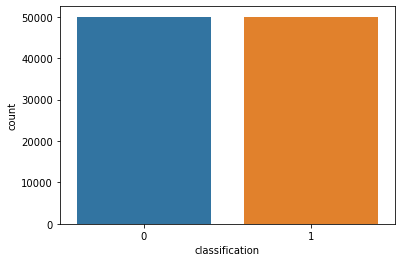

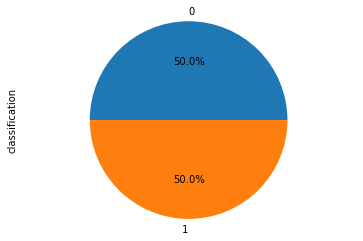

In [39]:

Visualize(data)


In [40]:
LogisticRegressionModel(data)




============================== LogisticRegression Model Evaluation ==============================

Cross Validation Mean Score:
 0.9398142857142858

Model Accuracy:
 0.9422571428571429

Confusion matrix:
                   Predicted to be Benign  Predicted to be Malware
Actually Benign                    32569                     2353
Actually Malware                    1689                    33389

Classification report:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94     34922
           1       0.93      0.95      0.94     35078

    accuracy                           0.94     70000
   macro avg       0.94      0.94      0.94     70000
weighted avg       0.94      0.94      0.94     70000


Run Time in seconds:  25.1462385599998
Run Time in mintues:  0.4191039759999967
